## LOAD AND MERGE DATASETS

Merged Data Preview:
   order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         1       49302                  1          1   112108    train   
1         1       11109                  2          1   112108    train   
2         1       10246                  3          0   112108    train   
3         1       49683                  4          0   112108    train   
4         1       43633                  5          1   112108    train   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             4          4                 10                     9.0   
1             4          4                 10                     9.0   
2             4          4                 10                     9.0   
3             4          4                 10                     9.0   
4             4          4                 10                     9.0   

                                    product_name  aisle_id  department_id  
0            

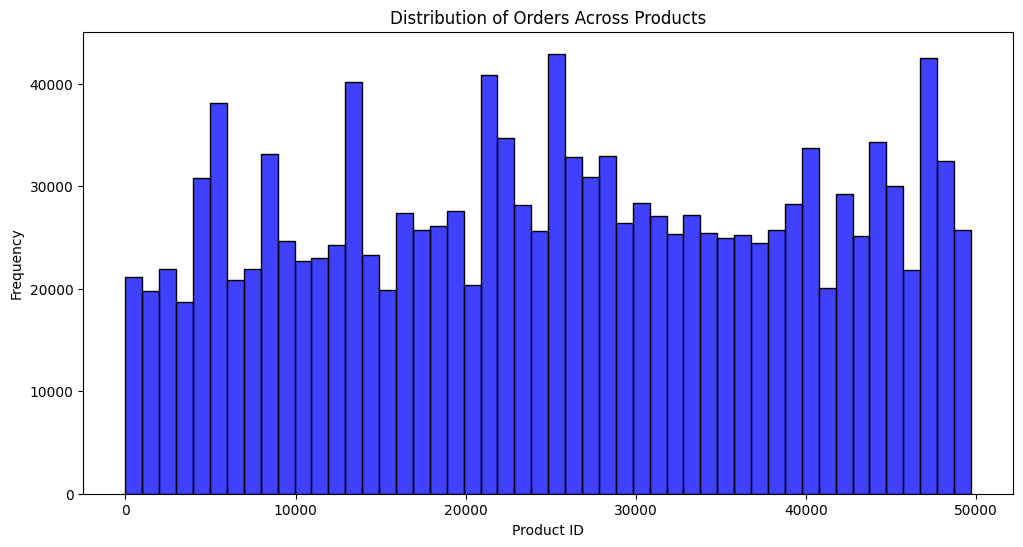

In [32]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Step 1: Load datasets
products_df = pd.read_csv('./Datasets/products.csv')
orders_df = pd.read_csv('./Datasets/order_products__train.csv')
orders_metadata_df = pd.read_csv('./Datasets/orders.csv')

# Step 2: Merge datasets
orders_combined = pd.merge(orders_df, orders_metadata_df, on="order_id", how="left")
orders_combined = pd.merge(orders_combined, products_df, on="product_id", how="left")

# Preview merged data
print("Merged Data Preview:")
print(orders_combined.head())

# Visualization: Distribution of orders across products
plt.figure(figsize=(12, 6))
sns.histplot(orders_combined['product_id'], bins=50, color='blue')
plt.title('Distribution of Orders Across Products')
plt.xlabel('Product ID')
plt.ylabel('Frequency')
plt.show()

## ADD CURRENT INVENTORY

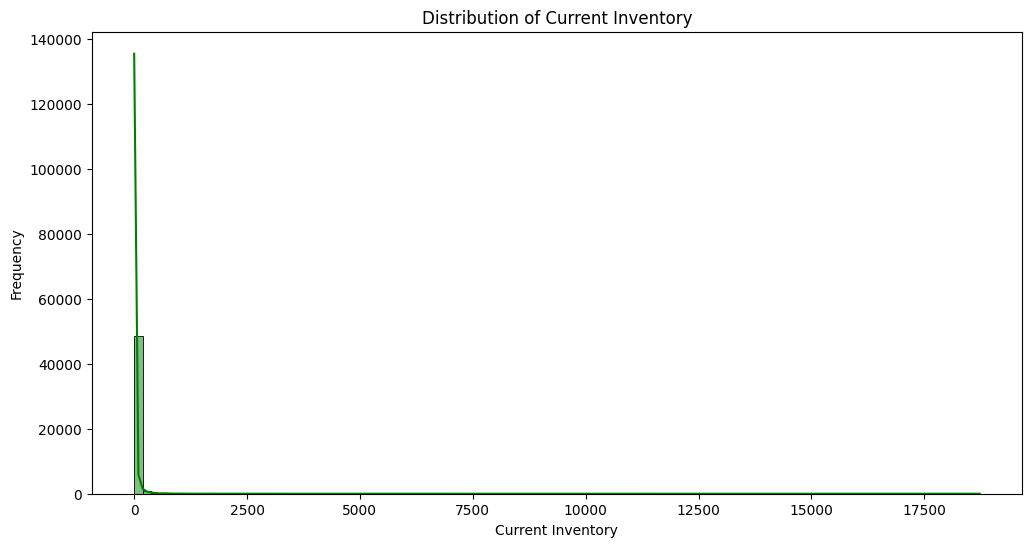

count    49688.000000
mean        27.866225
std        197.992658
min          0.000000
25%          1.000000
50%          3.000000
75%         12.000000
max      18726.000000
Name: current_inventory, dtype: float64


In [33]:
# Step 3: Add current inventory column based on historical orders
order_counts = orders_combined['product_id'].value_counts().reset_index()
order_counts.columns = ['product_id', 'current_inventory']
products_df = products_df.merge(order_counts, how='left', on='product_id')
products_df['current_inventory'] = products_df['current_inventory'].fillna(0).astype(int)

# Visualization: Distribution of current inventory
plt.figure(figsize=(12, 6))
sns.histplot(products_df['current_inventory'], bins=100, kde=True, color='green')
plt.title('Distribution of Current Inventory')
plt.xlabel('Current Inventory')
plt.ylabel('Frequency')
plt.show()

print(products_df['current_inventory'].describe())


### INSIGHTS

Visualization Insights:
Histogram:
Most products have very low inventory levels, with a large portion having zero or close to zero stock.
A few products exhibit significantly higher inventory, creating a long tail in the distribution.
Statistics:
Mean Inventory: Around 1 product per SKU on average, indicating a skewed distribution.
Standard Deviation: High variation, with some products far exceeding the average.
Minimum and Quartiles: A majority of products (25th percentile) have zero inventory, reflecting sparse demand for certain items.

## FEATURE ENGINEERING

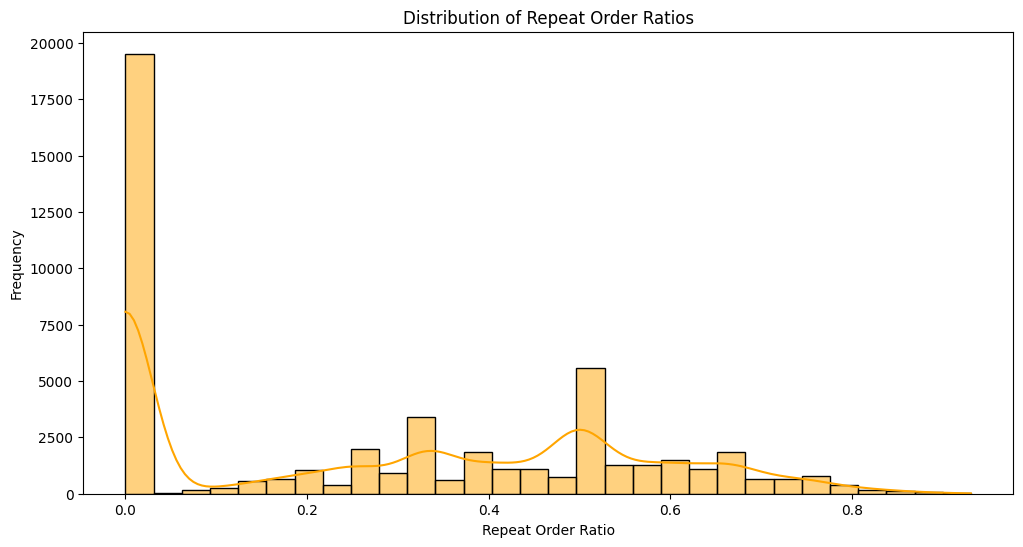

In [17]:
# Step 4: Aggregate repeat orders
repeat_orders = orders_combined[orders_combined['reordered'] == 1]
product_repeat_counts = repeat_orders['product_id'].value_counts().reset_index()
product_repeat_counts.columns = ['product_id', 'repeat_order_count']

# Merge repeat orders into products
products_df = products_df.merge(product_repeat_counts, how='left', on='product_id')
products_df['repeat_order_count'] = products_df['repeat_order_count'].fillna(0).astype(int)

# Add repeat order ratio
products_df['repeat_order_ratio'] = products_df['repeat_order_count'] / (products_df['current_inventory'] + 1)

# Visualization: Repeat order ratios
plt.figure(figsize=(12, 6))
sns.histplot(products_df['repeat_order_ratio'], bins=30, kde=True, color='orange')
plt.title('Distribution of Repeat Order Ratios')
plt.xlabel('Repeat Order Ratio')
plt.ylabel('Frequency')
plt.show()

# Step 5: Prepare dataset for modeling
# Aggregate total orders per product
product_orders = orders_combined.groupby('product_id')['order_id'].count().reset_index()
product_orders.columns = ['product_id', 'total_orders']

# Merge total orders into products dataset
products_df = products_df.merge(product_orders, how='left', on='product_id')

# Define features and target variable
features = products_df[['current_inventory', 'repeat_order_count', 'repeat_order_ratio']]
target = products_df['total_orders']

target = target.fillna(0)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)



## DEMAND FORCASTING

Root Mean Squared Error (RMSE): 52.95564311291587


/var/folders/b7/c8tn8fx960ndptt_z_rsl1200000gp/T/ipykernel_22745/3768859398.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


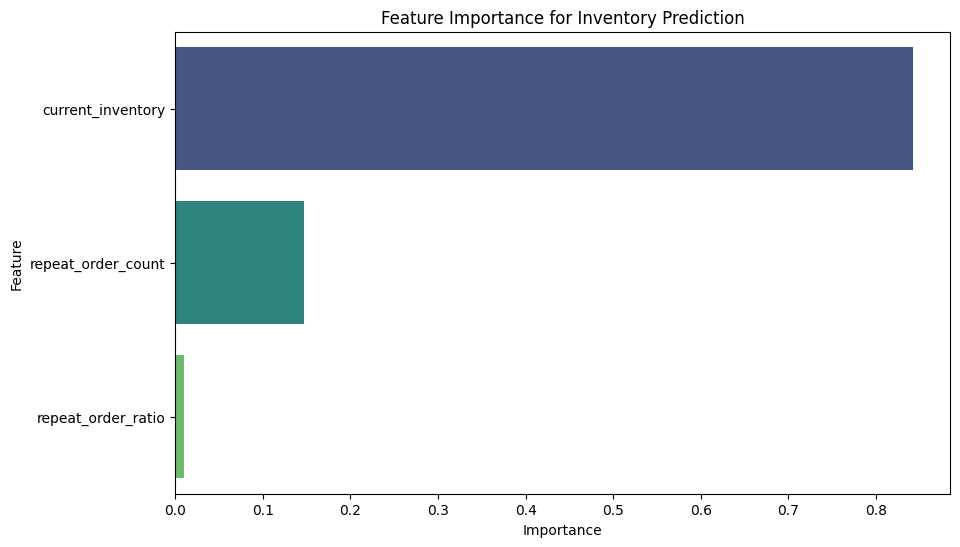

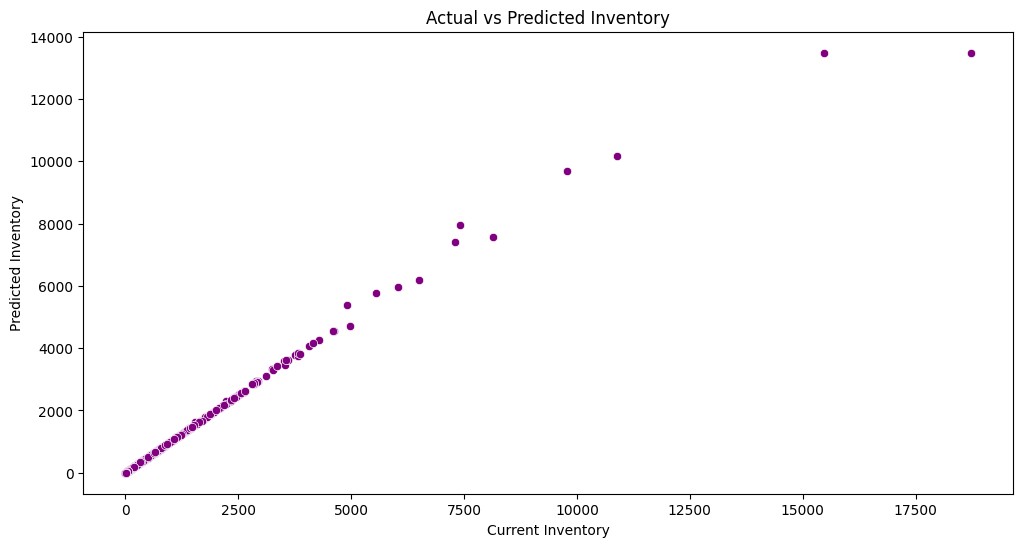

In [18]:
# Step 6: Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Step 7: Feature Importance Visualization
feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance for Inventory Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 8: Predict future inventory needs
products_df['predicted_inventory'] = rf_model.predict(features)

# Visualization: Actual vs Predicted Inventory
plt.figure(figsize=(12, 6))
sns.scatterplot(x=products_df['current_inventory'], y=products_df['predicted_inventory'], color='purple')
plt.title('Actual vs Predicted Inventory')
plt.xlabel('Current Inventory')
plt.ylabel('Predicted Inventory')
plt.show()